# Front Matter
URL: https://medium.com/towards-artificial-intelligence/whatsapp-group-chat-analysis-using-python-and-plotly-89bade2bc382
Notebook: https://github.com/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis.ipynb

In [7]:
%%capture
import sys
!{sys.executable} -m pip install emoji plotly

In [6]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image

## Data Preparation
1. The plain text file has to be parsed and tokenized in order to be stored in a DataFrame.
Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}

In [47]:
def startsWithDateAndTime(s):
    #pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9][0-9]) (AM|PM|am|pm)? -'
    pattern ='^([‎[0-9]+)/([0-9]+)(/)([0-9]+), ([0-9]+):[0-9]+:[0-9]+ (AM|PM|am|pm)]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split('] ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    date = date.split('[')[1]
    message = ' '.join(splitLine[1:])
    splitMessage = message.split(': ') 
    if len(splitMessage) > 1:
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None    
    return date, time, author, message

## Parse Text File

In [65]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '019futurego.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

### Print Participants

In [67]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
#
# remove messages created by None
df = df.dropna()
df.head()

,Date,Time,Author,Message
2,2018-06-20,11:09:59 AM,Dennis Lee,"Hi Erica, I’ve emailed u instructions on how t..."
3,2018-06-20,11:11:51 AM,Dennis Lee,Let me know after you have endorse it
4,2018-06-20,7:14:40 PM,Erica Sim,‎image omitted
5,2018-06-20,7:15:43 PM,Erica Sim,Thanks. You may be given or asked to join co...
6,2018-06-20,7:17:26 PM,Dennis Lee,👌🏽👍🏼


## Group Stats

In [75]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [76]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 893
Media: 0
Emojis: 41
Links: 21


## Participants

In [77]:
df.Author.unique()

array(['Dennis Lee', 'Erica Sim', 'Andy S(247813)'], dtype=object)

In [78]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1
messages_df["emojicount"]= df['emoji'].str.len()

# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Dennis Lee -
Messages Sent 224
Words per message 14.388392857142858
Media Messages Sent 0
Emojis Sent 9
Links Sent 8

Stats of Erica Sim -
Messages Sent 342
Words per message 16.464912280701753
Media Messages Sent 0
Emojis Sent 27
Links Sent 10

Stats of Andy S(247813) -
Messages Sent 327
Words per message 13.932721712538227
Media Messages Sent 0
Emojis Sent 5
Links Sent 3



## Emoji Stats

In [79]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('👌', 9), ('👍🏼', 4), ('👌🏽', 3), ('😬', 3), ('🙂', 3), ('🤣', 3), ('👍', 2), ('👏', 2), ('😕', 1), ('🙃', 1), ('😱', 1), ('😉', 1), ('🙄', 1), ('😐', 1), ('😁', 1), ('🤪', 1), ('😑', 1), ('😂', 1), ('😭', 1), ('🌈', 1)]


In [80]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,👌,9
1,👍🏼,4
2,👌🏽,3
3,😬,3
4,🙂,3
5,🤣,3
6,👍,2
7,👏,2
8,😕,1
9,🙃,1


## Activity Stats

In [81]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

Text(0, 0.5, 'Time')

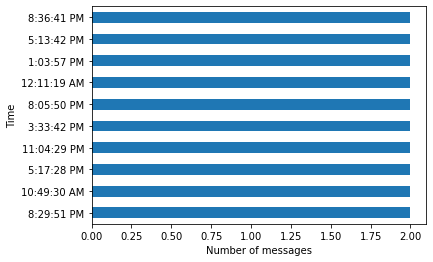

In [82]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

2018-06-08    64
2019-08-05    40
2018-08-17    36
2018-08-16    33
2020-08-05    23
              ..
2020-08-07     1
2020-05-29     1
2018-08-09     1
2018-07-29     1
2019-01-25     1
Name: Date, Length: 125, dtype: int64


Text(0, 0.5, 'Date')

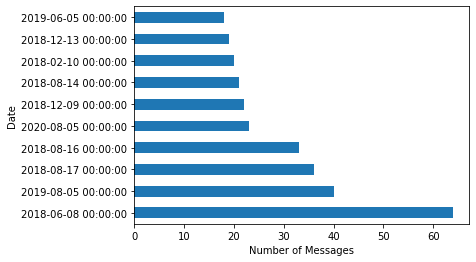

In [83]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')